## **Fine-tuning BERT for named-entity recognition**
We undertook this project as a learning experience. We aim to explore the working of BERT with the help of PyTorch and fine tune it to classify tokens by wordpiece and achieve custom NER. We have experimented on two datasets with over 100 thousand data points.

This model has BERT as its base architecture, with a token classification head on top, allowing it to make predictions at the token level, rather than the sequence level. Named entity recognition is typically treated as a token classification problem, so that's what we are going to use it for.

We use the idea of **transfer learning**, i.e. first pretraining a large neural network in an unsupervised way, and then fine-tuning that neural network on a task of interest. In this case, BERT is a neural network pretrained on 2 tasks: masked language modeling and next sentence prediction. Now, we are going to fine-tune this network on a NER dataset. Fine-tuning is supervised learning, so this means we will need a labeled dataset.




In [1]:
!pip install transformers seqeval[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=202a6eb8ac0697f854341929e92450cadf330ed7094a06e50363ffe3622864f6
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

2025-11-11 18:57:36.075149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762887456.256891      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762887456.312152      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#### **Downloading and preprocessing the data**
Named entity recognition (NER) uses a specific annotation scheme, which is defined (at least for European languages) at the *word* level. An annotation scheme that is widely used is called **[IOB-tagging](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)**, which stands for Inside-Outside-Beginning. Each tag indicates whether the corresponding word is *inside*, *outside* or at the *beginning* of a specific named entity. The reason this is used is because named entities usually comprise more than 1 word.

Let's have a look at an example. If you have a sentence like "Barack Obama was born in Hawaï", then the corresponding tags would be   [B-PERS, I-PERS, O, O, O, B-GEO]. B-PERS means that the word "Barack" is the beginning of a person, I-PERS means that the word "Obama" is inside a person, "O" means that the word "was" is outside a named entity, and so on. So one typically has as many tags as there are words in a sentence.

Here, we will use a NER dataset from [Kaggle](https://www.kaggle.com/namanj27/ner-dataset) that is already in IOB format. One has to go to this web page, download the dataset, unzip it, and upload the csv file to this notebook. Let's print out the first few rows of this csv file:

In [4]:
# legal NER
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratikpujarichef/legal-ner-dataset")

In [5]:
legal_data = pd.read_csv(f"{path}/data/NER_TRAIN/train_judgement_bio.csv")

legal_data.head()

,tokens,BIO_tags
0,"['\n\n', '(', '7', ')', 'On', 'specific', 'que...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,"['He', 'was', 'also', 'asked', 'whether', 'Agy...","['O', 'O', 'O', 'O', 'O', 'B-OTHER_PERSON', 'O..."
2,"[' \n', '5.2', 'CW3', 'Mr', 'Vijay', 'Mishra',...","['O', 'O', 'O', 'O', 'B-WITNESS', 'I-WITNESS',..."
3,"['You', 'are', 'hereby', 'asked', 'not', 'to',...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,"['The', 'pillion', 'rider', 'T.V.', 'Satyanara...","['O', 'O', 'O', 'B-OTHER_PERSON', 'I-OTHER_PER..."


In [6]:
legal_data = legal_data.rename(columns={'tokens':'sentence'})
legal_data = legal_data.rename(columns={'BIO_tags':'word_labels'})
# Remove first and last character from each string
legal_data['word_labels'] = legal_data['word_labels'].str[1:-1]
legal_data['sentence'] = legal_data['sentence'].str[1:-1]

legal_data['sentence'] = (
    legal_data['sentence']
    .str.replace("'", '', regex=False)    # remove single quotes
    .str.replace(',', ' ', regex=False)   # replace commas with spaces
)
legal_data['word_labels'] = (
    legal_data['word_labels']
    .str.replace("'", '', regex=False)    # remove single quotes
    .str.replace(" ", '', regex=False)    # remove spaces
)

legal_data.head(10)

,sentence,word_labels
0,\n\n ( 7 ) On specific query by the B...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-OR..."
1,He was also asked whether Agya < span ...,"O,O,O,O,O,B-OTHER_PERSON,O,O,O,O,O,O,O,O,O,O,O..."
2,\n 5.2 CW3 Mr Vijay Mishra Deputy M...,"O,O,O,O,B-WITNESS,I-WITNESS,O,O,O,O,B-ORG,I-OR..."
3,You are hereby asked not to carry out ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The pillion rider T.V. Satyanarayana Murt...,"O,O,O,B-OTHER_PERSON,I-OTHER_PERSON,I-OTHER_PE..."
5,if the argument of the learned counse...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
6,After all the steps at the stage of in...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
7,PW--2 Chandregowda is the younger brother...,"O,B-WITNESS,O,O,O,O,O,O,O,O,O"
8,What is the main offence in the charges...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
9,He had prepared G.D. No . 7 on 19.8.19...,"O,O,O,O,O,O,O,O,B-DATE,O,O,O"


In [7]:
legal_data['sentence'][0]

'\\n\\n  (  7  )  On  specific  query  by  the  Bench  about  an  entry  of  Rs  .  1 31 37 500  on  deposit  side  of  Hongkong  Bank  account  of  which  a  photo  copy  is  appearing  at  p.  40  of  assessee  "s"  paper  book     learned  authorised  representative  submitted  that  it  was  related  to  loan  from  broker     Rahul  &  Co.  on  the  basis  of  his  submission  a  necessary  mark  is  put  by  us  on  that  photo  copy  .'

In [8]:
#to use medical data
data = legal_data

Let's check how many sentences and words (and corresponding tags) there are in this dataset:

In [9]:
data.count()

sentence       9435
word_labels    9435
dtype: int64

As we can see, there are approximately 9,435 sentences in the dataset.
Let's have a look at the different NER tags, and their frequency:

Some tags may be underrepresented. Let's print them by frequency (highest to lowest):

In [10]:
# Split by comma and flatten the list
tag_counts = (
    data['word_labels']
    .str.split(',')      # split each sentence into a list
    .explode()           # expand lists into individual rows
    .str.strip()         # <-- remove leading/trailing spaces
    .value_counts()      # count each tag
)

print(tag_counts)

word_labels
O                 300249
I-PRECEDENT        14962
I-PROVISION         5784
I-CASE_NUMBER       4797
I-STATUTE           4155
I-DATE              3299
I-ORG               3012
I-COURT             2859
B-OTHER_PERSON      2653
B-PROVISION         2384
I-OTHER_PERSON      2120
B-DATE              1885
B-STATUTE           1804
B-ORG               1441
B-GPE               1398
B-PRECEDENT         1351
B-COURT             1293
B-CASE_NUMBER       1040
B-WITNESS            881
I-WITNESS            767
B-JUDGE              567
I-RESPONDENT         465
B-PETITIONER         464
I-JUDGE              403
I-PETITIONER         395
B-RESPONDENT         324
I-GPE                296
Name: count, dtype: int64


We create 2 dictionaries: one that maps individual tags to indices, and one that maps indices to their individual tags. This is necessary in order to create the labels (as computers work with numbers = indices, rather than words = tags) - see further in this notebook.

In [11]:
all_tags = (
    data['word_labels']
    .str.split(',')          # Split into lists
    .explode()               # Flatten all lists into one column
    .str.strip()             # Remove leading/trailing spaces
)
labels_to_ids = {k: v for v, k in enumerate(sorted(all_tags.unique()))}
ids_to_labels = {v: k for v, k in enumerate(sorted(all_tags.unique()))}
labels_to_ids

{'B-CASE_NUMBER': 0,
 'B-COURT': 1,
 'B-DATE': 2,
 'B-GPE': 3,
 'B-JUDGE': 4,
 'B-ORG': 5,
 'B-OTHER_PERSON': 6,
 'B-PETITIONER': 7,
 'B-PRECEDENT': 8,
 'B-PROVISION': 9,
 'B-RESPONDENT': 10,
 'B-STATUTE': 11,
 'B-WITNESS': 12,
 'I-CASE_NUMBER': 13,
 'I-COURT': 14,
 'I-DATE': 15,
 'I-GPE': 16,
 'I-JUDGE': 17,
 'I-ORG': 18,
 'I-OTHER_PERSON': 19,
 'I-PETITIONER': 20,
 'I-PRECEDENT': 21,
 'I-PROVISION': 22,
 'I-RESPONDENT': 23,
 'I-STATUTE': 24,
 'I-WITNESS': 25,
 'O': 26}

In [12]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.ffill()
data.head()

,sentence,word_labels
0,\n\n ( 7 ) On specific query by the B...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-OR..."
1,He was also asked whether Agya < span ...,"O,O,O,O,O,B-OTHER_PERSON,O,O,O,O,O,O,O,O,O,O,O..."
2,\n 5.2 CW3 Mr Vijay Mishra Deputy M...,"O,O,O,O,B-WITNESS,I-WITNESS,O,O,O,O,B-ORG,I-OR..."
3,You are hereby asked not to carry out ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The pillion rider T.V. Satyanarayana Murt...,"O,O,O,B-OTHER_PERSON,I-OTHER_PERSON,I-OTHER_PE..."


In [13]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,\n\n ( 7 ) On specific query by the B...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-OR..."
1,He was also asked whether Agya < span ...,"O,O,O,O,O,B-OTHER_PERSON,O,O,O,O,O,O,O,O,O,O,O..."
2,\n 5.2 CW3 Mr Vijay Mishra Deputy M...,"O,O,O,O,B-WITNESS,I-WITNESS,O,O,O,O,B-ORG,I-OR..."
3,You are hereby asked not to carry out ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The pillion rider T.V. Satyanarayana Murt...,"O,O,O,B-OTHER_PERSON,I-OTHER_PERSON,I-OTHER_PE..."


In [14]:
import re

# Define a regex that matches strings containing only 'O' and ','
pattern = r'^[O,]+$'

mask = data['word_labels'].str.match(pattern, na=False)

# Randomly sample 90% of those matching rows
drop_sample = data[mask].sample(frac=0.9, random_state=42)

# Drop those sampled rows
data2 = data.drop(drop_sample.index)

data2.head()

,sentence,word_labels
0,\n\n ( 7 ) On specific query by the B...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-OR..."
1,He was also asked whether Agya < span ...,"O,O,O,O,O,B-OTHER_PERSON,O,O,O,O,O,O,O,O,O,O,O..."
2,\n 5.2 CW3 Mr Vijay Mishra Deputy M...,"O,O,O,O,B-WITNESS,I-WITNESS,O,O,O,O,B-ORG,I-OR..."
4,The pillion rider T.V. Satyanarayana Murt...,"O,O,O,B-OTHER_PERSON,I-OTHER_PERSON,I-OTHER_PE..."
5,if the argument of the learned counse...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."


In [15]:
len(data)

9435

Let's verify that a random sentence and its corresponding tags are correct:

In [16]:
data.iloc[88].sentence

'He  denied  that  Pushkar  (  appellant  No.4  )  was  a  parking  attendant  in  Hotel  Le  Meridien  for  the  last  about  16  years  .'

In [17]:
data.iloc[88].word_labels

'O,O,O,B-PETITIONER,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,O,O,O,O,O,O,O'

#### **Statistics**

In [18]:
from collections import Counter

df = data
# --- Basic corpus stats ---
num_sentences = len(df)
print(f"Total sentences: {num_sentences}")

# Split tokens and tags
df['tokens'] = df['sentence'].apply(lambda x: x.split())
df['ner_tags'] = df['word_labels'].apply(lambda x: x.split(','))

# --- Token-level stats ---
total_tokens = df['tokens'].apply(len).sum()
avg_sentence_length = df['tokens'].apply(len).mean()

print(f"Total tokens: {total_tokens}")
print(f"Average sentence length: {avg_sentence_length:.2f}")

# --- Vocabulary ---
all_tokens = [token for sent in df['tokens'] for token in sent]
vocab = set(all_tokens)
print(f"Vocabulary size: {len(vocab)}")

# Most common words
word_freq = Counter(all_tokens)
print("\nTop 10 most common words:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

# --- NER Tag stats ---
all_tags = [tag for sent in df['ner_tags'] for tag in sent]
tag_freq = Counter(all_tags)
print("\nNER Tag distribution:")
for tag, freq in tag_freq.items():
    print(f"{tag}: {freq}")

# Token–Tag alignment sanity check
mismatch = df.apply(lambda x: len(x['tokens']) != len(x['ner_tags']), axis=1).sum()
print(f"\nSentences with mismatched tokens and tags: {mismatch}")

# sentence length stats
sentence_lengths = df['tokens'].apply(len)
print(f"Max sentence length: {sentence_lengths.max()}")
print(f"Min sentence length: {sentence_lengths.min()}")
print(f"Median sentence length: {sentence_lengths.median()}")


Total sentences: 9435
Total tokens: 346468
Average sentence length: 36.72
Vocabulary size: 25615

Top 10 most common words:
the: 26240
of: 15980
.: 13140
to: 7481
and: 7078
in: 6913
that: 4460
): 3866
a: 3547
was: 3546

NER Tag distribution:
O: 300249
B-ORG: 1441
I-ORG: 3012
B-OTHER_PERSON: 2653
I-OTHER_PERSON: 2120
B-WITNESS: 881
I-WITNESS: 767
B-GPE: 1398
B-STATUTE: 1804
B-DATE: 1885
I-DATE: 3299
B-PROVISION: 2384
I-PROVISION: 5784
I-STATUTE: 4155
B-COURT: 1293
I-COURT: 2859
B-PRECEDENT: 1351
I-PRECEDENT: 14962
B-CASE_NUMBER: 1040
I-CASE_NUMBER: 4797
I-GPE: 296
B-PETITIONER: 464
I-PETITIONER: 395
B-JUDGE: 567
I-JUDGE: 403
B-RESPONDENT: 324
I-RESPONDENT: 465

Sentences with mismatched tokens and tags: 6309
Max sentence length: 123
Min sentence length: 5
Median sentence length: 34.0


#### **Tag distribution**

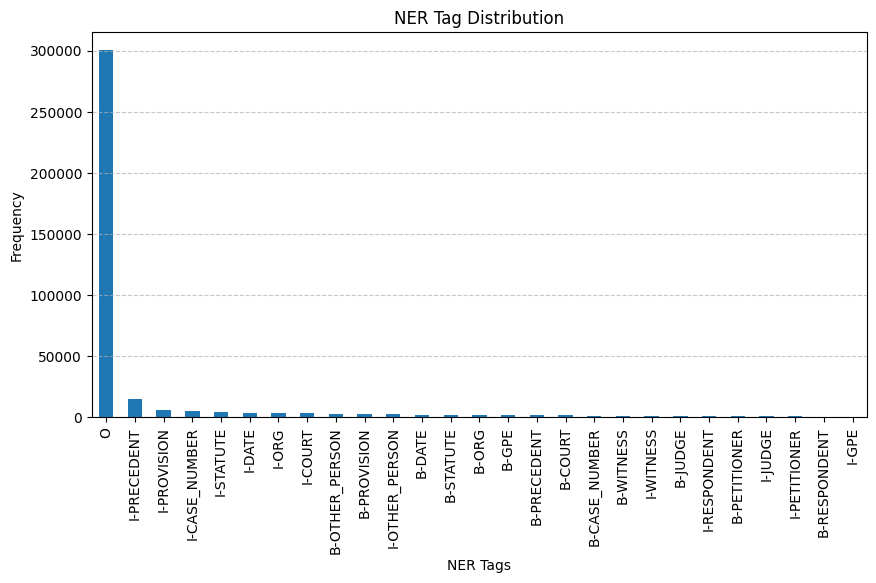

In [19]:
import matplotlib.pyplot as plt

tag_counts = data['word_labels'].str.split(',').explode().value_counts()

plt.figure(figsize=(10, 5))
tag_counts.plot(kind='bar')
plt.title("NER Tag Distribution")
plt.xlabel("NER Tags")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### **Preparing the dataset and dataloader**

Now that our data is preprocessed, we can turn it into PyTorch tensors such that we can provide it to the model. Let's start by defining some key variables that will be used later on in the training/evaluation process:

In [20]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

A tricky part of NER with BERT is that BERT relies on **wordpiece tokenization**, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!

For example, if you have word like "Washington" which is labeled as "b-gpe", but it gets tokenized to "Wash", "##ing", "##ton", then one approach could be to handle this by only train the model on the tag labels for the first word piece token of a word (i.e. only label "Wash" with "b-gpe"). This is what was done in the original BERT paper, see Github discussion [here](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063).


Below, we define a regular PyTorch [dataset class](https://pytorch.org/docs/stable/data.html) (which transforms examples of a dataframe to PyTorch tensors). Here, each sentence gets tokenized, the special tokens that BERT expects are added, the tokens are padded or truncated based on the max length of the model, the attention mask is created and the labels are created based on the dictionary which we defined above. Word pieces that should be ignored have a label of -100 (which is the default `ignore_index` of PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).









In [21]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index] # Keep as a single string
        word_labels = self.data.word_labels[index].split(",")

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(
        sentence.split(),
        is_split_into_words=True, padding='max_length', truncation=True, max_length=self.max_len, return_offsets_mapping=False)

        labels = [labels_to_ids[label] for label in word_labels] #convert using mapping

        # Create -100 labels and align word-level labels to tokens
        encoded_labels = np.ones(len(encoding["input_ids"]), dtype=int) * -100

        word_ids = encoding.word_ids()  # Map tokens to word indices where they came from
        previous_word_idx = None

        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            elif word_idx != previous_word_idx: #skip same word
                # Only label if the word_idx is within the bounds of the labels list
                if word_idx < len(labels):
                  encoded_labels[idx] = labels[word_idx]  # label only first subword
            previous_word_idx = word_idx

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        return item


  def __len__(self):
        return self.len

Now, based on the class we defined above, we can create 2 datasets, one for training and one for testing. Let's use a 80/20 split:

In [22]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (9435, 4)
TRAIN Dataset: (7548, 4)
TEST Dataset: (1887, 4)


Let's have a look at the first training example:

In [23]:
training_set[2]

{'input_ids': tensor([  101,  1999,  2250,  3380,  8040,  5385,  2153,  8636,  2004,  2019,
          2019,  6895, 24435,  2373,  2001,  7843,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

Let's verify that the input ids and corresponding targets are correct:

In [24]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
the         26
first       26
issue       26
raises      26
the         26
question    26
whether     26
the         26
undertaking  26
of          26
the         26
company     26
had         26
been        26
transferred  26
to          26
the         26
corporation  26
and         26
if          26
so          26
whether     26
the         26
settlement  26
-           -100
of          26
august      26
25          26
1965        2
between     15
the         15
company     15
and         26
the         26
union       26
was         26
binding     26
on          26
the         26
corporation  26
.           26
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD] 

Now, let's define the corresponding PyTorch dataloaders:

In [25]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

#### **Defining the model**

Here we define the model, BertForTokenClassification, and load it with the pretrained weights of "bert-base-uncased". The only thing we need to additionally specify is the number of labels (as this will determine the architecture of the classification head).

Note that only the base layers are initialized with the pretrained weights. The token classification head of top has just randomly initialized weights, which we will train, together with the pretrained weights, using our labelled dataset. This is also printed as a warning when you run the code cell below.

Then, we move the model to the GPU.

In [26]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

#### **Training the model**





In [27]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
print(initial_loss)

tensor(3.1774, device='cuda:0', grad_fn=<NllLossBackward0>)


In [28]:
print(labels)

tensor([[-100,   26,    0,   13,   13,   13,   26,   26,   26,   26,   26, -100,
         -100,   26,   26,   26,   26, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100]], device='cuda:0')


verify that the logits of the neural network have a shape of (batch_size, sequence_length, num_labels):

In [29]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 27])

In [30]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

Training loop partly sourced from - https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344


In [31]:
train_losses, val_losses = [], [] # store data for plots

In [32]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        #loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        #tr_loss += loss.item()

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        tr_logits = outputs.logits

        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 1000==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 1000 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [33]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 1000 training steps: 3.119321346282959
Training loss per 1000 training steps: 0.5319163586379594
Training loss epoch: 0.44141387677145405
Training accuracy epoch: 0.8821404211263744
Training epoch: 2
Training loss per 1000 training steps: 0.48482921719551086
Training loss per 1000 training steps: 0.27625778563109904
Training loss epoch: 0.2723236778446497
Training accuracy epoch: 0.9099858035223721
Training epoch: 3
Training loss per 1000 training steps: 0.20596644282341003
Training loss per 1000 training steps: 0.2253352825694553
Training loss epoch: 0.22517673473518438
Training accuracy epoch: 0.9211506930997589
Training epoch: 4
Training loss per 1000 training steps: 0.18206799030303955
Training loss per 1000 training steps: 0.19496899527888586
Training loss epoch: 0.19124969802870256
Training accuracy epoch: 0.931192898634651
Training epoch: 5
Training loss per 1000 training steps: 0.0718994289636612
Training loss per 1000 training steps: 0.16563

#### **Evaluating the model**

Now that we've trained our model, we can evaluate its performance on the held-out test set (which is 20% of the data). Note that here, no gradient updates are performed, the model just outputs its logits.

In [34]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    all_labels = []
    all_predictions = []


    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            out = model(input_ids=ids, attention_mask=mask, labels=labels)

            loss, eval_logits = out.loss, out.logits
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            if idx % 1000==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 1000 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

            # Append labels and predictions for seqeval
            label_list = [ids_to_labels[id.item()] for id in labels]
            prediction_list = [ids_to_labels[id.item()] for id in predictions]
            all_labels.append(label_list)
            all_predictions.append(prediction_list)

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return all_labels, all_predictions

In [35]:
labels, predictions = valid(model, testing_loader)

Validation loss per 1000 evaluation steps: 0.1483287662267685
Validation Loss: 0.32952318122211877
Validation Accuracy: 0.9191128364297844


However, the accuracy metric is misleading, as a lot of labels are "outside" (O), even after omitting predictions on the [PAD] tokens. What is important is looking at the precision, recall and f1-score of the individual tags. For this, we use the seqeval Python library:

In [36]:
from seqeval.metrics import classification_report
print("Testing accuracy-")
print(classification_report(labels, predictions))

Testing accuracy-
              precision    recall  f1-score   support

 CASE_NUMBER       0.33      0.39      0.36       235
       COURT       0.48      0.52      0.50       268
        DATE       0.43      0.42      0.42       360
         GPE       0.41      0.31      0.35       232
       JUDGE       0.51      0.48      0.49       126
         ORG       0.28      0.30      0.29       278
OTHER_PERSON       0.46      0.46      0.46       562
  PETITIONER       0.26      0.40      0.31        80
   PRECEDENT       0.27      0.31      0.29       248
   PROVISION       0.38      0.42      0.40       509
  RESPONDENT       0.33      0.27      0.30        62
     STATUTE       0.36      0.41      0.39       376
     WITNESS       0.40      0.42      0.41       175

   micro avg       0.38      0.41      0.39      3511
   macro avg       0.38      0.39      0.38      3511
weighted avg       0.39      0.41      0.40      3511



#### **Visualize which entities the model is classifying well**

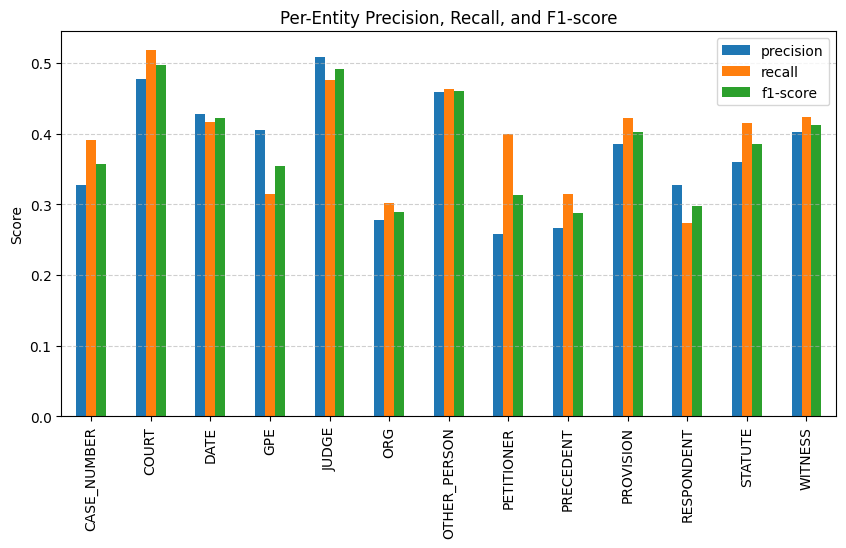

In [37]:
report = classification_report(labels, predictions, output_dict=True)
df_report = pd.DataFrame(report).transpose().drop(['micro avg', 'macro avg', 'weighted avg', 'samples avg'], errors='ignore')

df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,5))
plt.title("Per-Entity Precision, Recall, and F1-score")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### **Inference**

Let's test the model on new, unseen sentences.
Here, we use the prediction of the **first word piece of every word** (which is how the model was trained).

In [41]:
sentence = "The Supreme Court observed that procedural lapses cannot override substantive justice."

inputs = tokenizer(sentence.split(), is_split_into_words = True,
                    return_offsets_mapping=True,
                    padding='max_length',
                    truncation=True,
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
  #only predictions on first word pieces are important
  if mapping[0] == 0 and mapping[1] != 0:
    prediction.append(token_pred[1])
  else:
    continue

In [42]:
for word, label in zip(sentence.split(), prediction):
    print(f"{word:<15} {label}")


The             O
Supreme         B-COURT
Court           I-COURT
observed        O
that            O
procedural      O
lapses          O
cannot          O
override        O
substantive     O
justice.        O


#### **Saving the model for future use**

In [40]:
# import os

# directory = "./model"

# if not os.path.exists(directory):
#     os.makedirs(directory)

# tokenizer.save_vocabulary(directory)
# model.save_pretrained(directory)
# print('All files saved')